In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv("UCI_Credit_Card.csv")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
data=data.rename(columns={'default.payment.next.month':'Fraud'})
data.Fraud.value_counts()

0    23364
1     6636
Name: Fraud, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop("Fraud", axis = 1)
y = data.Fraud

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (30000, 24)
Shape of y:  (30000,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_test, y_pred):
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Precision Score: ", precision_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test,y_pred))
    
    df = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df1 = pd.DataFrame(df, columns = ['y_Actual','y_Predicted'])

    clf_confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames = ['Predicted'], colnames=['Actual'])

    sns.heatmap(clf_confusion_matrix, annot=True)
    plt.savefig('conf1.png')

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train, y_train)

lr_clf_pred = lr_clf.predict(X_test)

Accuracy Score:  0.784
Precision Score:  1.0
Recall Score:  0.0007710100231303007
Confusion Matrix:  [[4703    0]
 [1296    1]]
F1 Score:  0.0015408320493066254


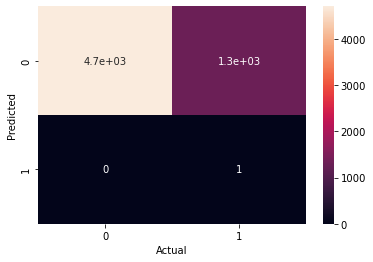

In [8]:
y_pred = lr_clf.predict(X_test)
evaluate_model(y_test, y_pred)

Accuracy Score:  0.8195
Precision Score:  0.7622549019607843
Recall Score:  0.23978411719352352
Confusion Matrix:  [[4606   97]
 [ 986  311]]
F1 Score:  0.36480938416422287


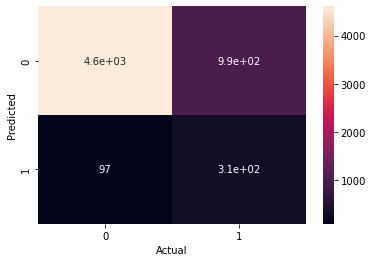

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr_clf_pipe = make_pipeline(StandardScaler(), LogisticRegression())
lr_clf_pipe.fit(X_train, y_train)

y_pred1 = lr_clf_pipe.predict(X_test)
evaluate_model(y_test, y_pred1)

# Support Vector Classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1,0.1,0.01,0.001,0.0001],
             'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose = 3)
grid.fit(X_train, y_train)

grid.best_estimator_

svc = SVC(C = 1000, gamma=0.0001)
svc.fit(X_train, y_train)
y_pred2 = svc.predict(X_test)
evaluate_model(y_test, y_pred2)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

def randomized_search(params, runs =20, clf = DecisionTreeClassifier(random_state=2)):
    rand_clf = RandomizedSearchCV(clf, params, n_iter=runs, cv=5, n_jobs=-1, random_state=2)
    rand_clf.fit(X_train, y_train)
    best_model = rand_clf.best_estimator_
    best_score = rand_clf.best_score_
    
    print("Training Score: {:.3f}".format(best_score))
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Score: {:.3f}".format(accuracy))
    
    return best_model

randomized_search(params={'criterion':['entropy','gini'],
                     'splitter':['random','best'],
                     'min_weight_fraction_leaf':[0.0,0.0025,0.005,0.0075,0.01],
                     'min_samples_split':[2, 3, 4, 5, 6, 8, 10],
                     'min_samples_leaf':[1, 0.01, 0.02, 0.03, 0.04],
                     'min_impurity_decrease':[0.0, 0.0005, 0.005, 0.05, 0.10, 0.15, 0.2],
                     'max_leaf_nodes':[10,15,20,25,30,45,50,None],
                     'max_features':['auto', 0.95, 0.90, 0.85, 0.80, 0.75, 0.70],
                     'max_depth':[None, 2, 4, 6, 8],
                     'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]})

Training Score: 0.819
Test Score: 0.827


DecisionTreeClassifier(max_depth=6, max_features=0.8,
                       min_impurity_decrease=0.0005, min_samples_leaf=0.01,
                       min_samples_split=10, random_state=2)

Accuracy Score:  0.8295
Precision Score:  0.7275747508305648
Recall Score:  0.33770239013107173
Confusion Matrix:  [[4539  164]
 [ 859  438]]
F1 Score:  0.4612954186413902


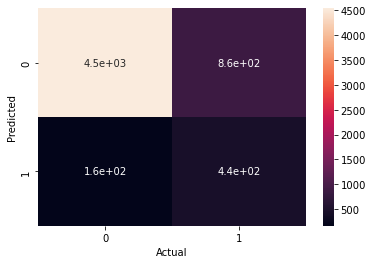

In [11]:
ds_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features=0.95,
                       max_leaf_nodes=45, min_samples_leaf=0.04,
                       min_samples_split=6, random_state=2)

ds_clf.fit(X_train, y_train)
pred4 = ds_clf.predict(X_test)
evaluate_model(y_test, pred4)

In [12]:
from sklearn.ensemble import RandomForestClassifier

randomized_search(params = {'min_samples_leaf':[1, 2, 4, 6, 8, 10, 20, 30],
                     'min_impurity_decrease':[0.0, 0.001, 0.05, 0.10, 0.15, 0.2],
                     'max_features':['auto', 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40],
                     'max_depth':[None, 2, 4, 6, 8, 10, 20],
                           }, clf = RandomForestClassifier(random_state=2))

Training Score: 0.820
Test Score: 0.828


RandomForestClassifier(max_depth=4, max_features=0.9, min_samples_leaf=10,
                       random_state=2)

Accuracy Score:  0.8243333333333334
Precision Score:  0.6644113667117727
Recall Score:  0.37856592135697764
Confusion Matrix:  [[4455  248]
 [ 806  491]]
F1 Score:  0.4823182711198428


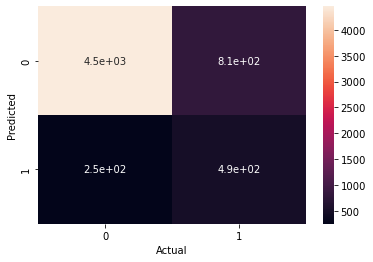

In [13]:
rf_clf = RandomForestClassifier(max_features=0.55, min_samples_leaf=2, random_state=2)
rf_clf.fit(X_train, y_train)
pred5 = rf_clf.predict(X_test)
evaluate_model(y_test, pred5)

In [14]:

from xgboost import XGBClassifier
xgb1 = XGBClassifier(colsample_bytree = 1.0,
                    learning_rate = 0.1,
                    max_depth =4,
                    n_estimators = 500,
                    subsample = 1.0)

eval_set = [(X_test, y_test)]

xgb1.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.64957
[1]	validation_0-logloss:0.61391
[2]	validation_0-logloss:0.58417
[3]	validation_0-logloss:0.55963
[4]	validation_0-logloss:0.53926
[5]	validation_0-logloss:0.52183
[6]	validation_0-logloss:0.50710
[7]	validation_0-logloss:0.49462
[8]	validation_0-logloss:0.48389
[9]	validation_0-logloss:0.47486
[10]	validation_0-logloss:0.46716
[11]	validation_0-logloss:0.46069
[12]	validation_0-logloss:0.45495
[13]	validation_0-logloss:0.45011
[14]	validation_0-logloss:0.44603
[15]	validation_0-logloss:0.44212
[16]	validation_0-logloss:0.43920
[17]	validation_0-logloss:0.43656
[18]	validation_0-logloss:0.43438
[19]	validation_0-logloss:0.43266
[20]	validation_0-logloss:0.43089
[21]	validation_0-logloss:0.42957
[22]	validation_0-logloss:0.42824
[23]	validation_0-logloss:0.42687
[24]	validation_0-logloss:0.42598
[25]	validation_0-logloss:0.42539
[26]	validation_0-logloss:0.42479
[27]	validation_0-logloss:0.42418
[28]	validation_0-logloss:0.42370
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy Score:  0.8295
Precision Score:  0.6962750716332379
Recall Score:  0.3747108712413261
Confusion Matrix:  [[4491  212]
 [ 811  486]]
F1 Score:  0.4872180451127819


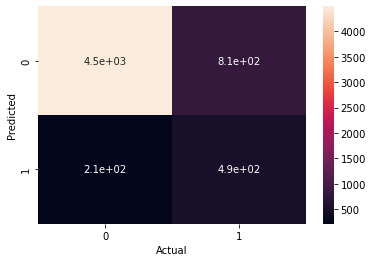

In [15]:
pred6 = xgb1.predict(X_test)
evaluate_model(y_test, pred6)

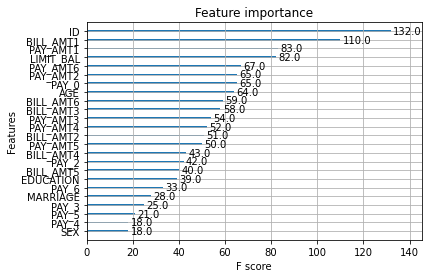

<Figure size 432x288 with 0 Axes>

In [16]:
from xgboost import plot_importance
plot_importance(xgb1)
plt.show()
plt.savefig('xgb1.png')

Accuracy Score:  0.8251666666666667
Precision Score:  0.6980830670926518
Recall Score:  0.3369313801079414
Confusion Matrix:  [[4514  189]
 [ 860  437]]
F1 Score:  0.4544981799271971


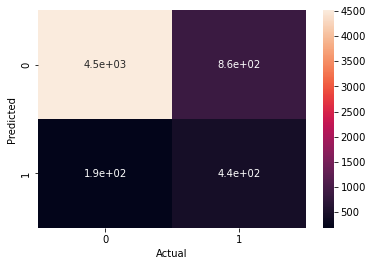

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1, max_depth=1, random_state=0)
gbdt.fit(X_train, y_train)

pred_gbdt = gbdt.predict(X_test)
evaluate_model(y_test, pred_gbdt)